# Séries temporais com Regressão Linear

**Autor**: [Rafael Barbosa]()

**Participação especial**: [Maykon Schots]()

*adicionar o linkedin novamente*

**Objetivo:** Temos uma série temporal de frequência diária de vendas que inicia em Jan/2020 e termina no final de Jul/2020. Queremos prever estas vendas para a próxima semana, dada as características que estão presentes no banco de dados abaixo.

## 1. Bibliotecas e configurações adicionais


In [1]:
#--- Bibliotecas iniciais

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays


#--- Configurações adicionais

plt.style.use("seaborn-muted")
pd.set_option("display.max_columns", None)

## 2. Carregando os dados

In [2]:
dados = pd.read_csv("data/output-dados-case.csv")

dados.head()

,Lead Created At,Lead Id,Purchase Source,JID,tempo_jornada,flag_jornada,flag_venda,Canal
0,2020-01-06 22:39,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,fb-geral-lookalike-dco,1,1.0,Primeiro Contato,0.0,FB
1,2020-02-21 19:18,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,sms-pre-carnaval-abandono,2,47.0,Ultimo Contato,0.0,SMS
2,2020-05-13 14:15,MSS-000031d0-5499-4e58-a88d-9afbcbb8ee9a-2019,yt-rmkt-videos-videovendas3,3,143.0,Ultimo Contato,0.0,YT
3,2020-07-23 22:28,MSS-00003bb2-b409-47b3-862f-e6c82b311d0c-2020,insta-bio,1,1.0,Primeiro Contato,0.0,FB
4,2020-05-12 22:51,MSS-0000610b-1170-47f5-990b-239d6eaef81b-2020,fb-rmkt-video-dco,1,1.0,Primeiro Contato,0.0,FB


In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309959 entries, 0 to 309958
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Lead Created At  309959 non-null  object 
 1   Lead Id          309959 non-null  object 
 2   Purchase Source  309959 non-null  object 
 3   JID              309959 non-null  int64  
 4   tempo_jornada    309959 non-null  float64
 5   flag_jornada     309959 non-null  object 
 6   flag_venda       293612 non-null  float64
 7   Canal            309959 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 18.9+ MB


- Observando o banco de dados, temos a informação de todas as interações em que o cliente teve com a loja

- A variável de data `Lead Created At` não está definida corretamente como data, somente como objeto

- A variável `flag_venda` indica se esta determinada interação cliente-loja resultou em uma compra ou não

- Então, o caminho para criar a nossa série temporal de vendas é:

    1. Criar uma nova variável que sempre vai ter o valor de 1, indicando a interação quantitativamente

    2. Filtrar somente as observações em que houveram venda

    3. Com isso, faremos uma agregação da soma de todas as vendas por dia

In [4]:
def modific_inicial_banco(df, var_data, var_flag_venda):
    
    """
    Função para ajustar em um formato inicial de séries temporais os dados recebidos   
    ------------
    Parâmetros:
    ------------
    
    df: DataFrame pandas;
    var_data: Variável de data a ser tratada
    var_flag_venda: Variável de indicador de venda ou não
    
    ------
    Saída:
    ------
    df: DataFrame pandas com o dia e a quantidade de vendas 
    """
    
    df1 = df.copy()
    
    df1[var_data] = pd.to_datetime(df1[var_data], format = "%Y-%m-%d")
    
    df1["indicador_leads"] = 1.0
    
    df1 = df1[df1[var_flag_venda] == 1].resample("D", on = var_data)["indicador_leads"].sum()
    
    return(df1.reset_index())

In [5]:
dados1 = modific_inicial_banco(df = dados, 
                               var_data = "Lead Created At", 
                               var_flag_venda = "flag_venda")

dados1.head()

,Lead Created At,indicador_leads
0,2020-01-01,47.0
1,2020-01-02,70.0
2,2020-01-03,48.0
3,2020-01-04,81.0
4,2020-01-05,73.0


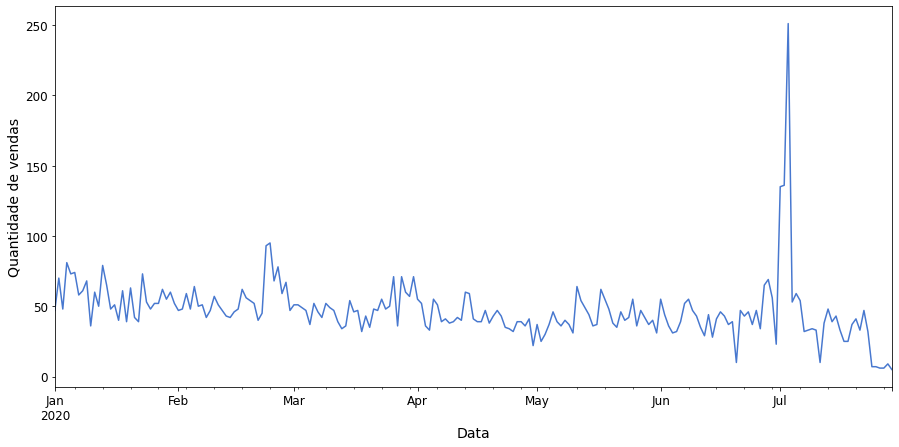

In [6]:
_ = dados1.plot(x = "Lead Created At", y = "indicador_leads", kind = "line", 
               figsize = [15, 7], legend = False)
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

## 3. Definindo a métrica: RMSE (Root Mean Squared Error)

$$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i}(y_i - \hat{y}_i)} $$

## 4. Tratando os outliers

- Como os outliers dessa série são visivelmente claros e específicos (início de Julho), então todos os valores de vendas acima de 100 serão considerados outliers

- Uma estratégia inicial, será considerar eles como nulos e utilizar diferentes estratégias de imputação para qual se adequa melhor. Entretanto, devido a limitação daquilo que está entre a cadeira e o computador, não houve como finalizar esta estratégia

- A estratégia será então utilizar uma interpolação linear

In [7]:
def outliers_maior_100(df, var):
    
    """
    Função para trocar os números maiores que 100 por NaNs e criar a interporlação
    ------------
    Parâmetros:
    ------------
    
    df: DataFrame pandas;
    var: Variável a ser tratada
        
    ------
    Saída:
    ------
    df: DataFrame pandas com o dia e a quantidade de vendas 
    """
    
    df1 = df.copy()
    
    df1[var] = df1[var].apply(lambda x: np.nan if x >= 100 else x).interpolate(method = "linear")
    
    return(df1)

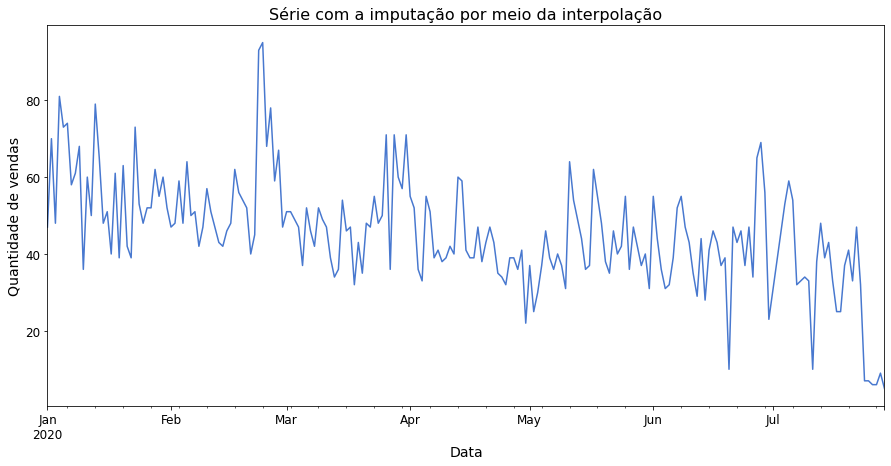

In [8]:
dados_ts = outliers_maior_100(df = dados1, var = "indicador_leads")

_ = dados_ts.plot(x = "Lead Created At", y = "indicador_leads", kind = "line", figsize = (15, 7), 
                legend = False)
_ = plt.title("Série com a imputação por meio da interpolação", fontsize = 16)
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

- Com isso, temos uma série temporal simples. Agora podemos criar um modelo de chute bem dummy para tentar prever a quantidade de vendas

- Antes do chute, temos que separar os dados em treino e teste

- Entretanto, séries temporais não devem ser divididas aleatoriamente devido a natureza sequencial de suas informações. Logo, existe uma separação adequada para esse tipo de problema, como podemos ver abaixo

## Separar em treino e teste (TS), como vai funcionar:

1. Separar em treino e teste
2. Criar o modelo dummie e o pika, este por último
3. Treinar no CV 
4. Fazer o kfolds dentro dos dados de treino

In [9]:
dados_ts.tail()

,Lead Created At,indicador_leads
206,2020-07-25,7.0
207,2020-07-26,6.0
208,2020-07-27,6.0
209,2020-07-28,9.0
210,2020-07-29,5.0


In [10]:
X = dados_ts["Lead Created At"]
y = dados_ts["indicador_leads"]

In [11]:
from sktime.forecasting.model_selection import temporal_train_test_split

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size = 0.3)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(147,) (147,) (64,) (64,)


In [13]:
y_train

0      47.0
1      70.0
2      48.0
3      81.0
4      73.0
       ... 
142    46.0
143    40.0
144    42.0
145    55.0
146    36.0
Name: indicador_leads, Length: 147, dtype: float64

## Criando o modelo dummy

In [14]:
#--- Setup dos pacotes

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sktime.forecasting.naive import NaiveForecaster

set_config(display = "diagram")

In [15]:
#--- Criando o modelo e fitando nos dados de treino

naive_ts = NaiveForecaster(strategy = "last")
naive_ts.fit(y_train)

NaiveForecaster()

In [16]:
from sktime.forecasting.naive import NaiveForecaster

tscv = TimeSeriesSplit(n_splits = 4)

scores = cross_val_score(estimator = naive_ts, X = X_train, y = y_train, 
                        cv = tscv, scoring = "neg_mean_squared_error")

scores

#for x in cv_ts:
#     print(x, end = " ")

/home/rafael/Documentos/Projetos_Externos/Grupo_DS_Avancado/ts_regressao1/venv1/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rafael/Documentos/Projetos_Externos/Grupo_DS_Avancado/ts_regressao1/venv1/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rafael/Documentos/Projetos_Externos/Grupo_DS_Avancado/ts_regressao1/venv1/lib/python3.8/site-packages/sktime/forecasting/naive.py", line 74, in fit
    self._set_fh(fh)
  File "/home/rafael/Documentos/Projetos_Externos/Grupo_DS_Avancado/ts_regressao1/venv1/lib/python3.8/site-packages/sktime/forecasting/base/_sktime.py", line 457, in _set_fh
    fh = check_fh(fh)
  File "/home/rafael/Documentos/Projetos_Externos/Grupo_DS_Avancado/t

array([nan, nan, nan, nan])

In [17]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84] TEST: [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  6